### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

### Globals

In [2]:
data_filepath = '../original_data/'
density_reports_filepath = data_filepath + 'DensityReports.xlsx'
historical_incidents_filepath = data_filepath + 'HistoricalIncidents.xlsx'
product_attributes_filepath = data_filepath + 'ProductAttributes.xlsx'
supplier_scorecard_filepath = data_filepath + 'SupplierScorecard.xlsx'

### Load Data

In [3]:
density_reports = pd.read_excel(density_reports_filepath)
product_attributes = pd.read_excel(product_attributes_filepath)
supplier_scorecard = pd.read_excel(supplier_scorecard_filepath)


## Data Preparation

### Basic Transformations

In [4]:
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

density_reports['PackagingQuality'] = density_reports['PackagingQuality'].str.upper()
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

['Good' 'Bad' 'GOOD' 'Uncertain' 'bad']
['GOOD' 'BAD' 'UNCERTAIN']


In [5]:
unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

# Define the mappings
supplier_mappings = {
    'SupplierA': 'A',
    'supplierA': 'A',
    'SuplA': 'A',
    'SupplierB': 'B',
    'SuppB': 'B',
    'SupplierC': 'C',
    'SupllierC': 'C',
    'SupplierD': 'D',
    'SupplierE': 'E',
    'SupplierF': 'F',
    'SPLF': 'F',
    'SupplierG': 'G',
    'supplierh': 'H',
    'SupplierH': 'H'
}
# Apply the mapping to standardize SupplierName
density_reports['SupplierName'] = density_reports['SupplierName'].map(supplier_mappings).fillna(density_reports['SupplierName'])

unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

['SupplierA' 'SupplierC' 'SupplierD' 'SupplierB' 'supplierA' 'SupplierF'
 'SupplierE' 'supplierh' 'SupplierH' 'SuppB' 'SupplierG' 'SupllierC'
 'SPLF' 'SuplA']
['A' 'C' 'D' 'B' 'F' 'E' 'H' 'G']


### Join Density Reports and Product Attributes Data

In [6]:
report_product_attributes = pd.merge(
    density_reports[["ProductReference", "SupplierName", "GarmentType", "Material", 
                     "Weight", "ProposedUnitsPerCarton", "ProposedFoldingMethod", 
                     "ProposedLayout", "PackagingQuality"
                     ]], 
    product_attributes[['ProductReference', 'Size', 'Collection']], 
    on="ProductReference", 
    how='inner'
    )

In [7]:
report_product_attributes.head()

,ProductReference,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,PackagingQuality,Size,Collection
0,PRD07271,A,Pants,Polyester,0.35,29.0,Method2,LayoutC,GOOD,S,Winter
1,PRD00861,C,T-Shirt,Denim,0.21,20.0,Method2,LayoutB,GOOD,M,Winter
2,PRD05391,A,Shirt,Cotton,0.20,31.0,Method1,LayoutA,GOOD,S,Winter
3,PRD05192,A,Coat,Cotton,1.30,5.0,Method1,LayoutD,GOOD,XL,Winter
4,PRD05735,A,Coat,Polyester,1.11,9.0,Method2,LayoutD,GOOD,M,Autumn


In [8]:
report_product_attributes.dtypes

ProductReference           object
SupplierName               object
GarmentType                object
Material                   object
Weight                    float64
ProposedUnitsPerCarton    float64
ProposedFoldingMethod      object
ProposedLayout             object
PackagingQuality           object
Size                       object
Collection                 object
dtype: object

## Association Analysis (Cramer's V) - Product Attributes

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))


In [10]:
categorical_columns = ['SupplierName', 'GarmentType', 'Material', 'ProposedFoldingMethod', 
                       'ProposedLayout', 'PackagingQuality', 'Size', 
                       'Collection']
results = []

for i, col1 in enumerate(categorical_columns):
    for col2 in categorical_columns[i+1:]:
        v = cramers_v(report_product_attributes[col1], report_product_attributes[col2])
        results.append({'Var1': col1, 'Var2': col2, "CramersV": v})

cramers_v_df = pd.DataFrame(results).sort_values(by='CramersV', ascending=False)
cramers_v_df

,Var1,Var2,CramersV
13,Material,ProposedFoldingMethod,0.437950
9,GarmentType,ProposedLayout,0.366254
4,SupplierName,PackagingQuality,0.179167
14,Material,ProposedLayout,0.085525
15,Material,PackagingQuality,0.070383
19,ProposedFoldingMethod,PackagingQuality,0.059047
10,GarmentType,PackagingQuality,0.033600
22,ProposedLayout,PackagingQuality,0.033488
11,GarmentType,Size,0.028838
17,Material,Collection,0.028337


## Correlation Analysis - Supplier Metrics

In [11]:
supplier_scorecard.isnull().sum()

SupplierName                  0
Month                         0
PackagesHandled               0
BadPackagingRate (%)          0
TotalIncidents                0
AverageCostPerIncident (€)    0
OnTimeDeliveryRate (%)        0
AnomaliesDetected             0
dtype: int64

In [12]:
supplier_scorecard.dtypes

SupplierName                   object
Month                          object
PackagesHandled                 int64
BadPackagingRate (%)          float64
TotalIncidents                  int64
AverageCostPerIncident (€)    float64
OnTimeDeliveryRate (%)        float64
AnomaliesDetected               int64
dtype: object

In [13]:
# define correlation matrix for numerical columns
numerical_columns = supplier_scorecard.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = supplier_scorecard[numerical_columns].corr()

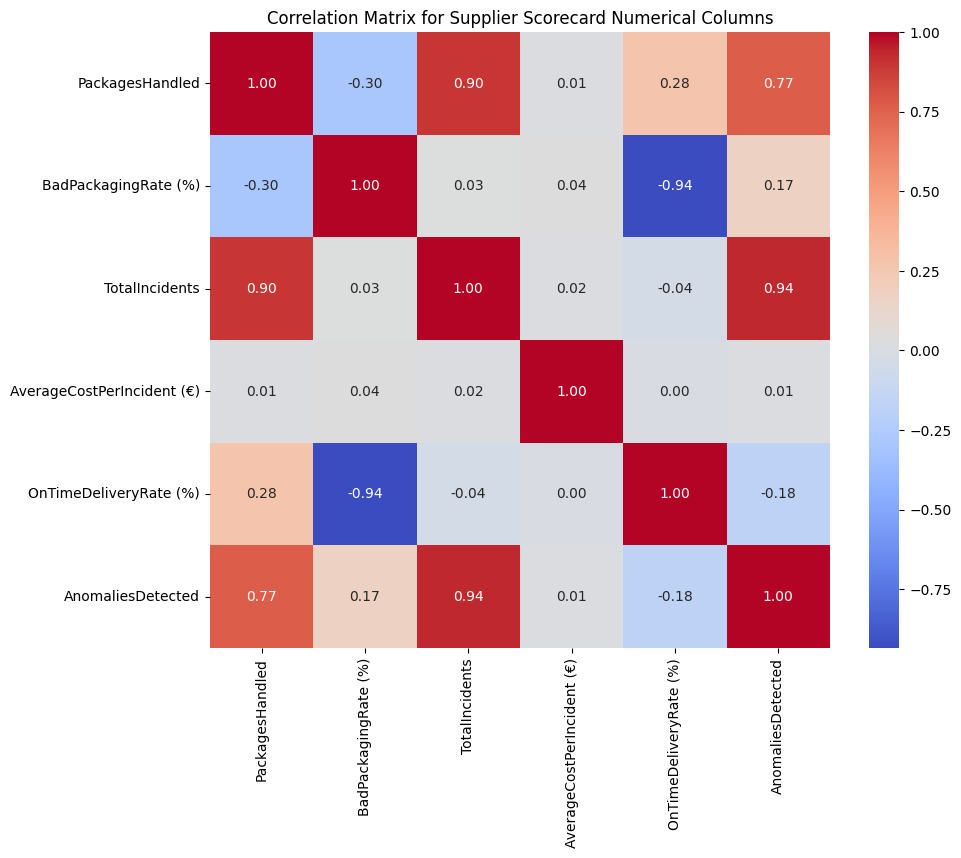

In [14]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Supplier Scorecard Numerical Columns')
plt.show()

## Mutual Information Analysis

In [15]:
df = report_product_attributes.copy()

# Separate features and target, remove unnecessary columns
X = df.drop(columns=['PackagingQuality', 'ProductReference'])
y = df['PackagingQuality']

# Label encode all categorical variables (both features and target)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_encoded = X.copy()
discrete_features = []

for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col])
        discrete_features.append(True)
    else:
        discrete_features.append(False)  # float columns

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features=discrete_features)

# Present results
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MutualInformation': mi_scores
}).sort_values(by='MutualInformation', ascending=False)

print(mi_df)

                  Feature  MutualInformation
0            SupplierName           0.032411
2                Material           0.004629
5   ProposedFoldingMethod           0.003317
3                  Weight           0.002483
4  ProposedUnitsPerCarton           0.001434
1             GarmentType           0.001064
6          ProposedLayout           0.001050
7                    Size           0.000010
8              Collection           0.000004
